# HGSRouter example

This notebook uses `OptiWindNet` to route the collector system cables via `HGSRouter`.

## 🧬 HGS (Hybrid Genetic Search)

`HGSRouter` is a *metaheuristic based router* that applies *Hybrid Genetic Search (HGS)* to solve the wind farm network layout problem as a *Capacitated Vehicle Routing Problem (CVRP)*. It can handle both single and multiple substations and is well-suited for *fast and high-quality layouts*.

This router is slower than `EWRouter` but typically yields *better-quality solutions*, especially for medium and large windfarms with one substation.

### 🔧 Constructor: `HGSRouter(...)`

**Required arguments:**

| Argument     | Type  | Description                                                                                                             |
| ------------ | ----- | ----------------------------------------------------------------------------------------------------------------------- |
| `time_limit` | `int` | Time limit (in seconds) which controls how long the genetic algorithm can search for better solutions. |

**Optional arguments:**

| Argument       | Type          | Description                                                                             |
| -------------- | ------------- | --------------------------------------------------------------------------------------- |
| `feeder_limit` | `int or None` | Maximum number of feeders (only used in single-substation problems).                    |
| `max_iter`     | `int`         | Maximum number of local iterations (default: `10`).                                     |
| `balanced`     | `bool`        | If `True`, tries to balance the number of turbines per feeder. |
| `seed`         | `int`         | Random seed for reproducibility (default: `0`).                                         |
| `verbose`      | `bool`        | If `True`, prints routing details and warnings.                                         |

**✅ Example**

```python
router = HGSRouter(time_limit=60, feeder_limit=10, balanced=True)
wf = WindFarmNetwork(cables=..., turbinesC=..., substationsC=..., router=router)
wf.optimize()
```
* HGSRouter trades speed for *higher-quality layouts* and is particularly useful when:

  * A better solution is worth longer runtime (respect to `EWRouter`)
  * The number of turbines connected to each feeder needs to be balanced

* In *multi-substation networks*, the `feeder_limit` is ignored (not yet supported).

>This router is implemented [vidalt/HGS-CVRP: Modern implementation of the hybrid genetic search (HGS) algorithm specialized to the capacitated vehicle routing problem (CVRP). This code also includes an additional neighborhood called SWAP\*.](https://github.com/vidalt/HGS-CVRP)
>
>HGSRouter can only produce *radial* topologies. Since a *radial* topology is a special case of the *branched* topology, solutions produced by this method can be used to warm-start both *branched*- and *radial*-topology models.

## Load data

import required modules

In [13]:
from optiwindnet.api import WindFarmNetwork, HGSRouter

In [14]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

Create an instance of `wfn` using `.from_pbf()`


In [15]:
wfn = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables= [(7, 2000.0)])

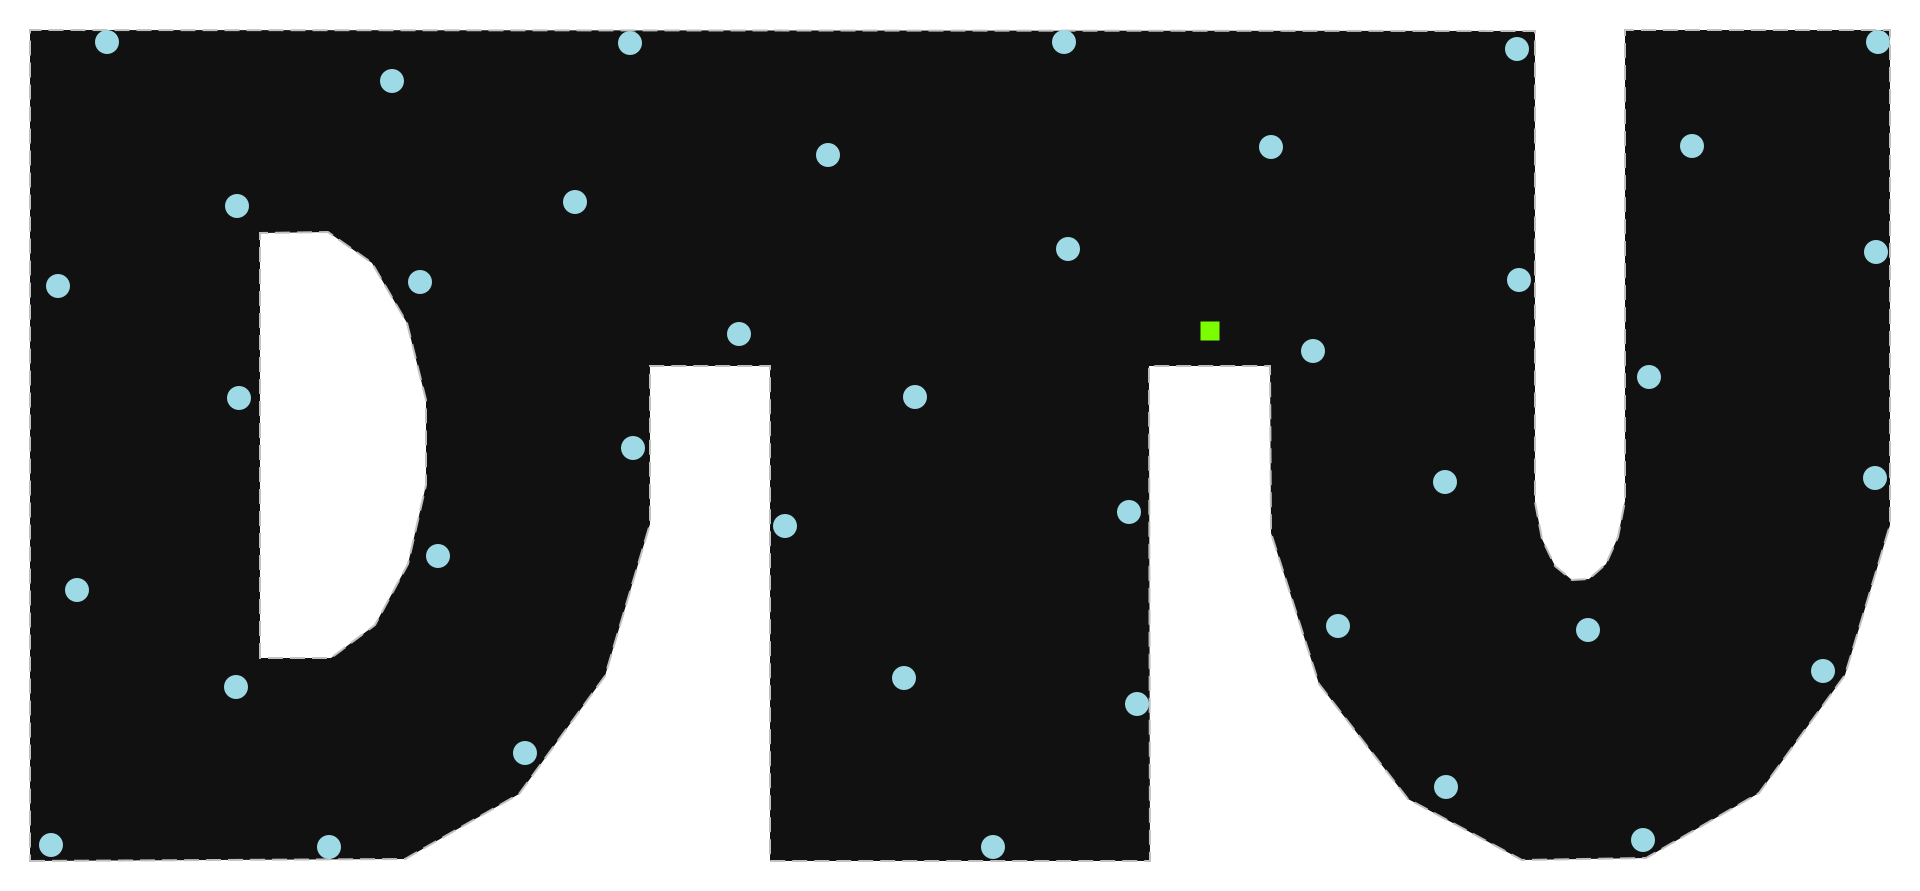

In [16]:
wfn

## Optimize with HGSRouter

In [17]:
router = HGSRouter(time_limit=10)

In [18]:
res = wfn.optimize(router=router)

In [19]:
wfn.length()

1596.158040734816

### Get solution_time

We can see the solution time for HGS using:
```python
wfn.S.graph['solution_time']
```
It prints the computation time for each subgroup of turbines assigned to a specific substation.
The HGS algorithm groups turbines and allocates each group to a substation prior to optimization.

In [20]:
print(wfn.S.graph['solution_time'])

0.06


### Choosing `time_limit` wisely

Based on the solution times observed in the previous step, we can make an informed decision about the time limit for the HGS router. If increasing the time limit does not significantly improve the solution (e.g., does not result in a noticeably shorter cable length), we can consider reducing it to save computational resources. In this case, a time limit of 0.1 second appears to be sufficient, as it is well above all the solution times.

In [21]:
router_reduced_timelimit = HGSRouter(time_limit=0.1)
res_reduced_timelimit = wfn.optimize(router=router_reduced_timelimit)

In [22]:
print(wfn.S.graph['solution_time'])

0.05


#### Check the length

We can see that, as expected, reducing the time limt from 10 seconds to 1 seconds has not affected the resultant length.

In [23]:
wfn.length()

1596.158040734816

### Plot the Optimized Network Graph

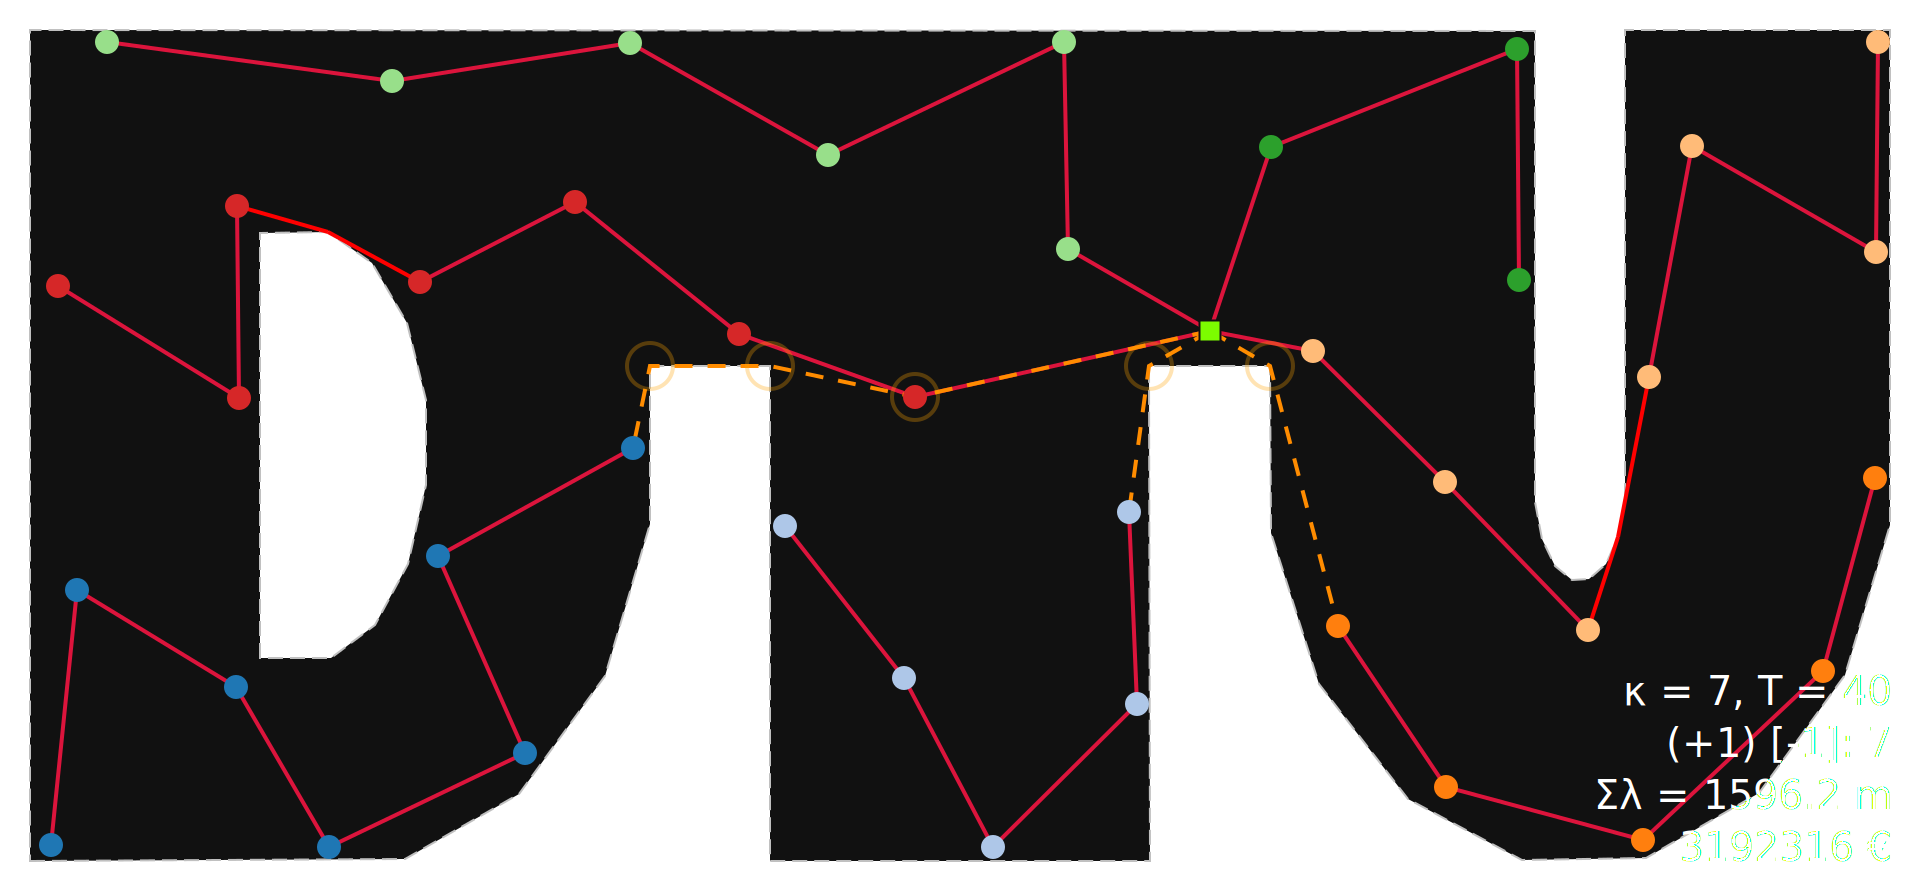

In [24]:
wfn